<div style="text-align: center;">
<h1><b>BURN MAPPING</b></h1>
</div>

This Notebook explores various methods to burn mapping.

<div style="text-align: center;">
<h2><b>Preface</b></h2>
</div>

**Objective**

Find binary classification of burn mapping. After a fire, a specific location (a pixel) is either burned or unburned. 


**Resources available**

4 Sentinel-2 bands:

+ B12 SWIR 2:       2190 nm

+ B11 SWIR 1:       1610 nm

+ B9  Water Vapour: 945 nm

+ B8 NIR:           842 nm

**Quality Inspection**

How good is the classification. Since we don't have too much of a ground truth. 

Quality can be checked against an official perimeter (not perfect).

For now, we can expect some False Positives, but the goal is to reduce them as much as possible.

**Benefit**

After binary burn mapping is done, a severity mapping is more meaningful.

    E.g: Burn Mapping as a mask for BARC, better than BARC itself

**Acknowledgements**

We try our best to classify using only the 4 bands available. We have not yet know "the features" that can help with mapping 100% correctly, but a useful method is the goal of our team's. 

An area can be burned today, and shows less signal some time later. So the choice of pre-fire and post-fire data to map burn needs careful considerations in order to see the "true impact".

E.g: By choosing very close dates, one can see nothing as burned or a very far away distance in dates can be misleading for several reasons (the burned area is healing and shows less signal,...)

Snow, cloud coverage can be obstructions for the mapping.

Thus, burn mapping requires some assumptions we should make, nothing is perfect, but can be a useful source of study.

<u>We can't easily use ground truth</u>, 

    for example, the colour of burn can be very different, depending on various factors like the landscape, which was burned, ...

<div style="text-align: center;">
<h2><b>Observations</b></h2>
</div>

dNBR uses data from SWIR and NIR, which is made available to us. As fire progresses, we can see dNBR (between the first date and the date we are looking at) changes.

**The limitations of dNBR itself are**: 

1. fire likely amplifies signals of dNBR. However, the other direction is not always true.

    + Because of that, we can see unburned areas light up dNBR, and they stay consistent across the images (if we assume fire spreads, and changes in signal, then the areas were defintely unburned).

2. Weather conditions can introduce noise (cloud, smoke) into the dNBR, as seen in the video analysis, little noise still appears and it moves around.

3. Probably more...

<div style="text-align: center;">
<h2><b>Insights</b></h2>
</div>

**What can be done**

If signals are there today, they do not automatically mean "fire is there". If they completely disappear the next day, likely they are just noise.

**key**: burns dont unburn overnight.

If signals are there today, and the next image still shows it there, it shows a stability. Thus, it can be burned.

**Solution**:

We human tend to update our belief as we see more evidence, Bayesian method can be used here as the intuition is basically similar.

Today, there is nothing yet, we can say, likely, it is unburned. As days move, still nothing? More confidence in it being unburned. 

Suddenly ... there is signal, well, seems like it is burned! But not so sure, so I will move a bit of my skeptic aside, and have less confidence of it being unburned.

Days over day, as we do that, if the signal is consistent, we will keep updating and for long enough, the signal is evident and we can say:

    "It's likely burned"

**Bayesian method** is nice as we can extract uncertainty intervals pretty easily.

**Spatial idea:** As said, if we see signals, we have more confidence as it is BURNED, and IF there is signal of BURNED around (k nearest neighbours), it can be a rich source of evidence to even amplify our confidence.

**First Law of Geography**: Everything depends on everything else, but closer things are more so. In this case, locations closer to another locations which are believed to be burned, are likely to be burned as well!.

For now, let's ignore the 1st limitation and work on this solution.

<div style="text-align: center;">
<h2><b>The ... Math</b></h2>
</div>

**Prior distributions**

At the beginning, each pixel will be assigned with a prior distribution (basically, 2 million distributions). We will use a known one,

$
p_i(B) \sim Beta(\alpha = 1, \beta=1)
$

Since Beta is used to model probability, its support is (0, 1). And Beta(1,1) is the same as Uniform(0,1), which basically means **I don't know**.

For **the prediction of each pixel**, we will use its expected value, which is:

$
E[p_i(B)] = \frac{\alpha}{\alpha + \beta}
$,

basically the prior literally means, prediction = 0.5, which means ... no idea. We can always adjust this, as Bayesian is very sensitive to the prior distribution.

**New evidence**

In the light of new evidence, in our case, as we observe some signal of dNBR (either low or higher), we can adjust our belief accordingly.

How to adjust it? That's not simple, we need to make bunch of assumptions:

+ New evidence that is close to a confident burn should boost the confidence at that pixel faster (Spatial Information).

    This is essential, along the period of burning, it usually stays there longer where it starts. So the starting place has more chance to boost its confidence up, and it kinda enhances the confidence of places around it even more.

Let's say for every image, we update the posterior using the prior, and **the prior should use information from The Day Before**.

E.g: Weighted average of distribution of pixels around it.

**Chalenges:**

If a we assign prior to a pixel too early, and the fire really happened at that pixel area a while later, it would need days to really go back to random guess (50%) and then a while more to be confident.

It wouldn't be a problem if fire would not happen there, but we never know where the fire would start.

This method would need a long enough time after a fire starts in order to have it show up in the prediction.

**After burn is confirmed**:

We want to go back in time and track where did it start by focusing only on the previous mapping, fire progression.

<div style="text-align: center;">
<h2><b>Implementation</b></h2>
</div>

To implement this, just a few images are needed. We start from **Aug 25**, which seems to be the day of fire.

**Basically libraries**

Some are built in, some written by me.

In [1]:
from plot_tools import (
    plot, plot_multiple
)

import matplotlib.pyplot as plt

import numpy as np

from raster import Raster

from misc.general import htrim_3d

In [2]:
from barc import (
    NBR, dNBR
)

**Let's first retrieve dNBR of 2 days in a row, starting from 0825**

In [3]:
ref_date = 'fire_C11659/S2C_MSIL2A_20250825T191931_N0511_R099_T09UYU_20250826T000205_cloudfree.bin_MRAP_C11659.bin'
next_date_1 = 'fire_C11659/S2C_MSIL2A_20250828T192931_N0511_R142_T09UYU_20250828T225113_cloudfree.bin_MRAP_C11659.bin'
next_date_2 = 'fire_C11659/S2A_MSIL2A_20250830T193831_N0511_R142_T09UYU_20250831T011715_cloudfree.bin_MRAP_C11659.bin'

Load raster

In [4]:
raster_0 = Raster(ref_date)
raster_1 = Raster(next_date_1)
raster_2 = Raster(next_date_2)

Visualize

In [5]:
raster_0_dat = raster_0.read_bands(crop=1)
raster_1_dat = raster_1.read_bands(crop=1)
raster_2_dat = raster_2.read_bands(crop=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4857419..7.391111].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.41838658..7.8822293].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.317689..7.910881].


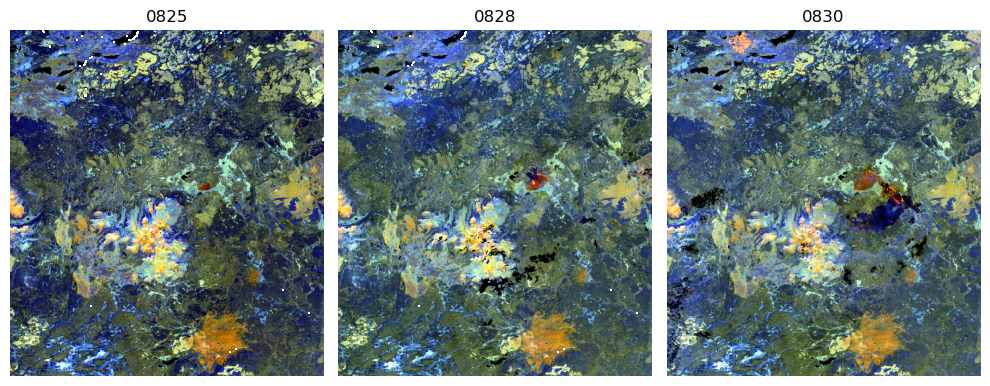

In [6]:
plot_multiple(
    X_list= [htrim_3d(raster_0_dat[..., :3]),
             htrim_3d(raster_1_dat[..., :3]),
             htrim_3d(raster_2_dat[..., :3])],
    title_list=['0825', '0828', '0830'],
    max_per_row=3,
    figsize=(10,5)
)

**dNBR**

1. Until 0828

In [23]:
_, _, dnbr_1 = dNBR(
    NIR_1=raster_0_dat[..., 3],
    SWIR_1=raster_0_dat[..., 0],
    NIR_2=raster_1_dat[..., 3],
    SWIR_2=raster_1_dat[..., 0]
)

_, _, dnbr_2 = dNBR(
    NIR_1=raster_0_dat[..., 3],
    SWIR_1=raster_0_dat[..., 0],
    NIR_2=raster_2_dat[..., 3],
    SWIR_2=raster_2_dat[..., 0]
)

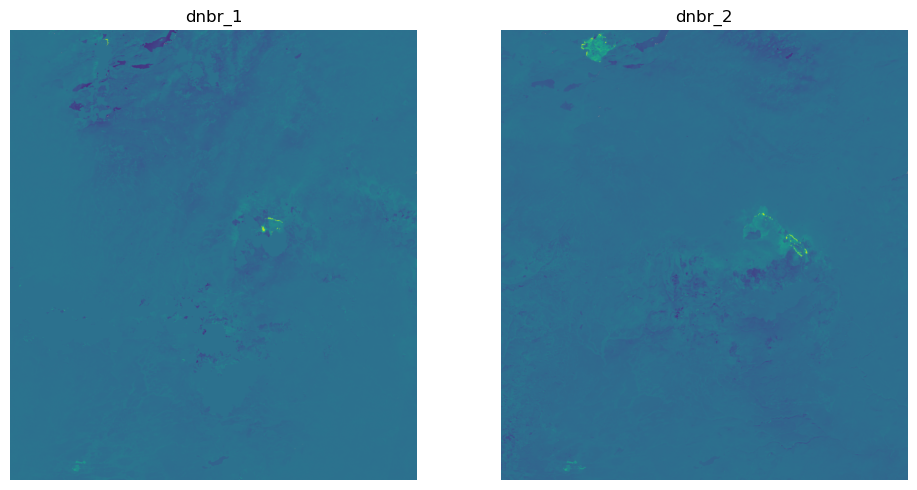

In [24]:
plot_multiple(X_list=[dnbr_1, dnbr_2],
              title_list=['dnbr_1', 'dnbr_2'], max_per_row=2, figsize=(10,5))

**BAYESIAN UPDATING**

**Prior choice**


We always start with a choice of prior distribution. For this case, we can reasonably say "I don't know" as we can assign a BETA distribution as.

$$
p_i(B) \sim Beta(1, 1)
$$

I chose this because **Beta(1,1) is basically Uniform(0,1)**. And Beta is used to model distribution of probability as well.

**By using known distribution**, we only need enough matrices to store it's parameter pair.

In [25]:
raster_0_dat.shape

(2991, 2707, 4)

In [26]:
alpha = np.ones((2991, 2707))
beta = np.ones((2991, 2707))

In [27]:
#Prediction demo, basically expectation of Beta Distribution.
alpha / (alpha + beta)

array([[0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
       ...,
       [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5]], shape=(2991, 2707))

The matrices filled with ones above, gives the prior for our prediction distribution. And after the image on 0828 (next day), we have evidence of dNBR values. 

**Conjugate**

Although beta is nice, but to get a beta back as posterior, one needs to use Binomial likelihood. It doesn't hurt trying, but let's see how binomial can be used here?

If we want to use another distribution, like a continuous, we might need to store a simulation data for each pixel. Which can easily blow up the memory (no nice conjugate pair)

$$
dNBR \sim Binomial(n, p)
$$

Where p is our prediction distribution, now being Beta. 

Honestly, I dont like this, but Binomial is used to count number of successes among a sample size, n.

In this case, we almost have to set n = 1 (Binomial -> Bernoulli), which literally means, did we observe dNBR or not :), clearly doesnt make sense.

So let's say, our evidence is 1 (evidence of burn) as 

$$(dNBR*1000+275)/5 >= 100
$$ 

(which is classified as medium severity).

In [30]:
def is_evidence(dnbr):

    return (dnbr * 1000 + 275) / 5 >= 100.0

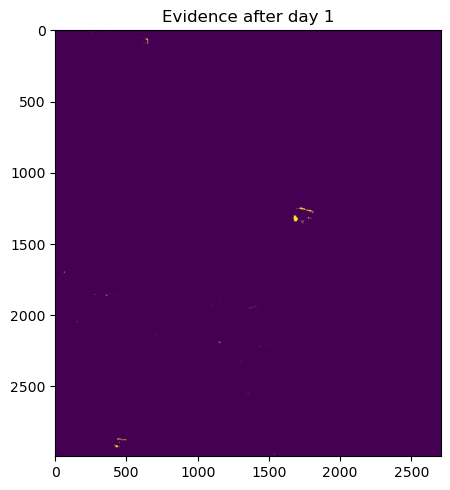

In [42]:
plot( is_evidence(dnbr_1) , title='Evidence after day 1', figsize= (8,5))

**Posterior**

This is probably the hardest part. 

We will have to agree on some thing, first the well known bayesian update formula **for each of the pixels**

$$
p_t(B | evidence) = \frac{p_t(evidence | B).p_t(B)}{p_t(evidence)}
$$

Where,
$p_t(B)$ means the prior probability of Burn at this pixel, we already had Beta(1,1) and it's really to be updated.

$p_t(evidence|B)$ is the likelihood under Burn, if it burns, what is the probability we will observe this evidence.

$p_t(evidence)$ is the marginal distribution of evidence.

**How to find the likelihood?**

$p_t(evidence|B)$

Again, this quantity means if this pixel is burned, what is the probability that we will have this evidence (dNBR). To achieve this, we can look at the big picture:

Along all pixels with prediction of being burned the day before, how many of them got this evidence today.

Sounds complicated but we will go through a demo.

In [45]:
evidence_1 = is_evidence(dnbr_1)

In [55]:
#Select a prediction threshold

alpha_1 = alpha + evidence_1
beta_1 = beta + ~evidence_1

In [56]:
prediction_1 = alpha_1 / (alpha_1 + beta_1)

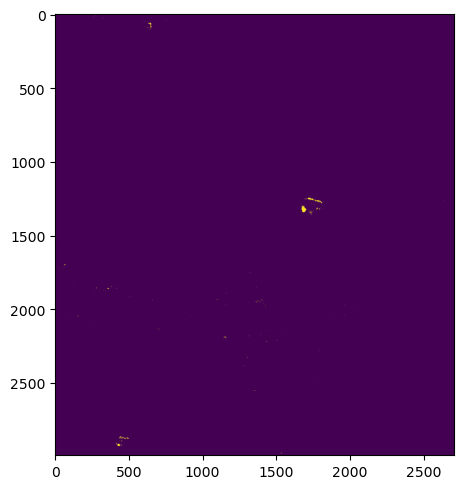

In [57]:
plot(prediction_1 >= 0.5,figsize= (8,5))

In [ ]:
evidence_2 = is_evidence(dnbr_2)

#Select a prediction threshold

alpha_2 = alpha_1 + evidence_2
beta_2  = beta_1 + ~evidence_2

In [59]:
prediction_2 = alpha_2 / (alpha_2 + beta_2)

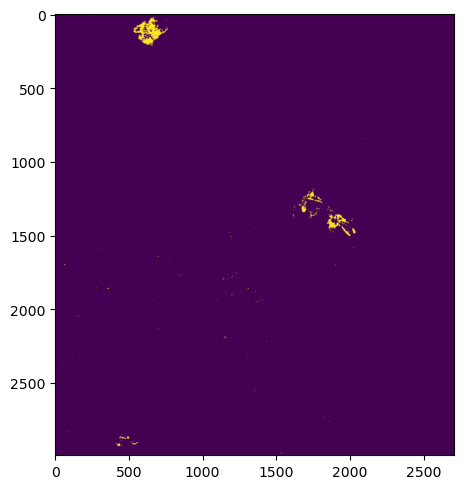

In [ ]:
plot(prediction_2 >= 0.5, figsize=(8,5))

**Assumption**:

A place needs signal continuously for at least 3 images to be classified as burn.

fire will not easily unburn within a few days.

Using that, the posterior can go to unburn direction to a certain level, and will not go below that (it idles until the new signal arrives).

Otherwise, long time of no signal at 1 place will make it almost right skewed and takes super long to revive.

You will understand why.

**Method 1:** 3 days method

New signal needs to stay for at least 3 days to be marked as burn.

Pros: 

+ Can be used to see how fire progressed.


Cons: 

+ All the noise will show up with low probability. Not clean.

+ 
